# Classification Tree

References

Implementation
https://www.youtube.com/watch?v=LDRbO9a6XPU  
https://github.com/L-ear/RandomForest/tree/master/RandomForest  
https://www.youtube.com/watch?v=Ud5XlhG8-gU&list=PLPOTBrypY74xS3WD0G_uzqPjCQfU6IRK-&index=4  
https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb  

Theory
https://rafalab.github.io/pages/649/section-11.pdf  
https://scikit-learn.org/stable/modules/tree.html#:~:text=Given%20training%20vectors,subsets  
https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=The%20problem%20of,tree%20were%20proposed  

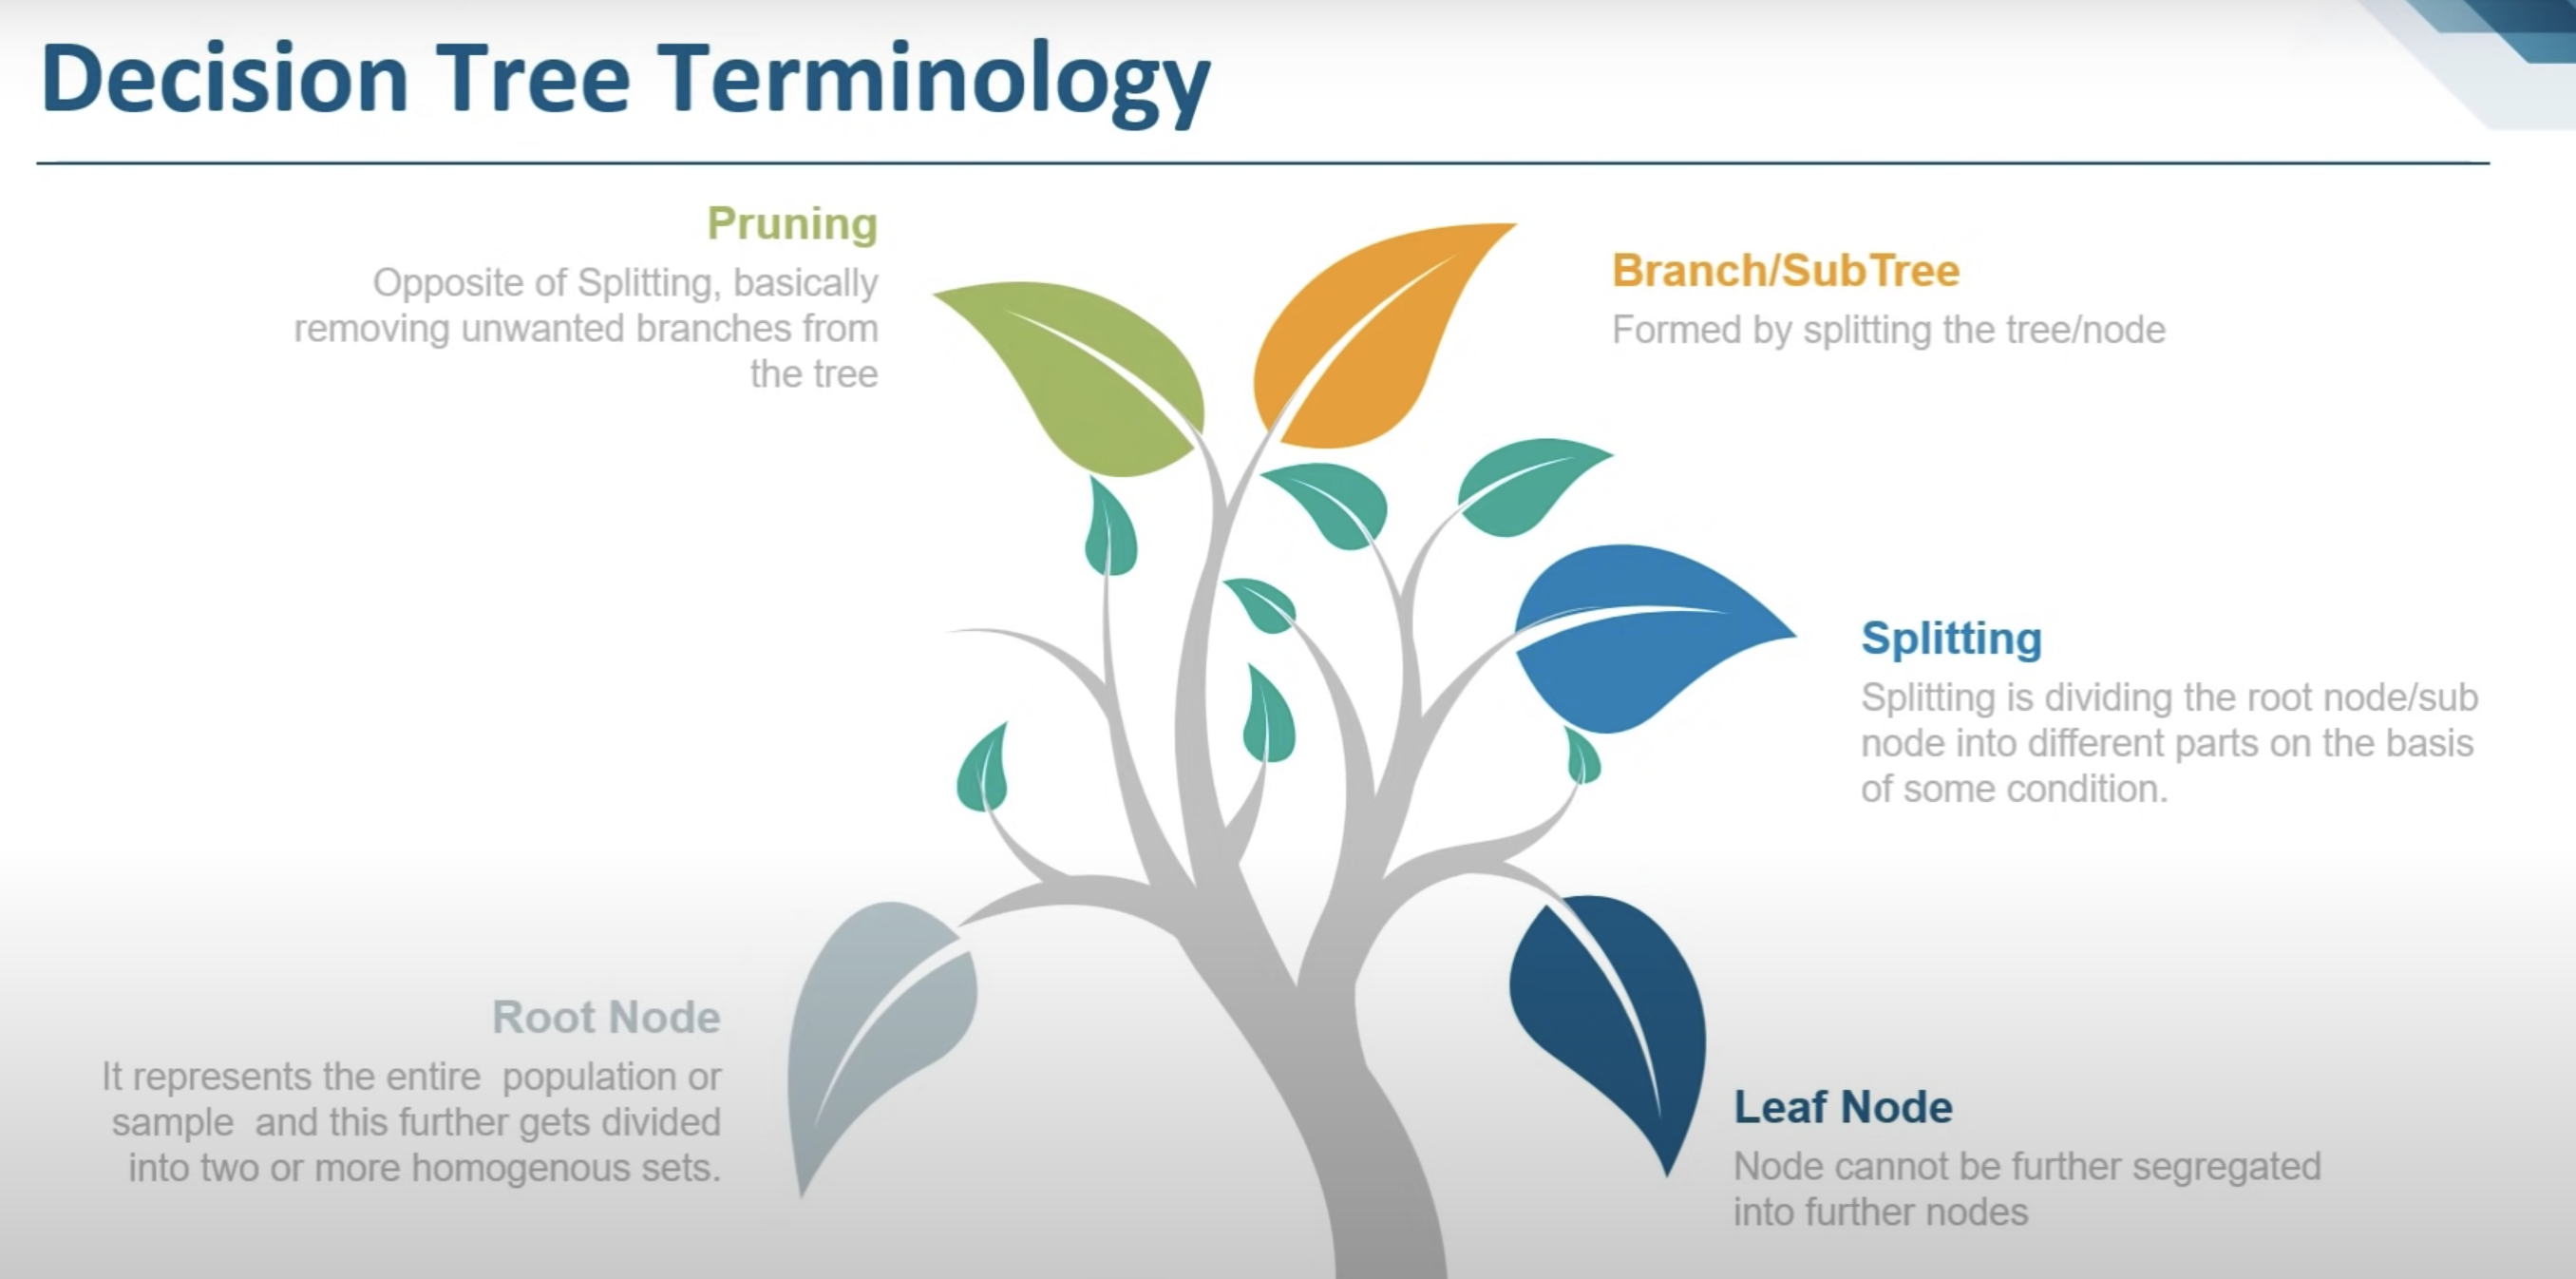

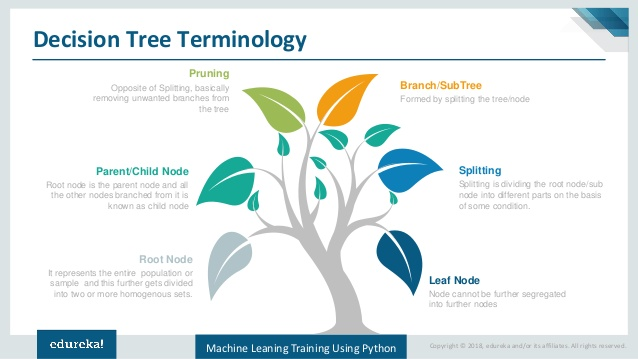

### Our decision tree estimator would like to have as much of the following hyperparameters as possible

In [1]:
# # Our decision tree estimator would like to have as much of the following hyperparameters as possible
# class Classification_tree:
#     def __init__(self, 
#                  criterion='gini',     # {“gini”, “entropy”}
#                  max_depth=None,       # int The maximum depth the tree can grow
#                  min_samples_split=2,  # int  The minimum number of samples required to split an internal node
#                  max_features=None,    # the maximum features to consider at each split
#                  random_state=None):    # control the randomness when growing the tree
#     pass         

In [2]:
import pandas as pd
import numpy as np

### Use Titanic data as a concrete example to help build trees

In [3]:
df = pd.read_csv('titanic.csv',usecols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked'])
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [4]:
y = df['Survived']
X = df.drop('Survived',axis=1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Do some data cleaning since algorithms cannot handle missing values

In [5]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X_train[['Age']] =imp.fit_transform(X_train[['Age']])

imp2 = SimpleImputer(strategy= 'most_frequent')
X_train[['Embarked']] =imp2.fit_transform(X_train[['Embarked']])

### One of the beauties of Decision Tree is its interpretability, i.e., the ability to visualize and explain how decisions are made.  
  
### We first try to code without any encoding of categorical variables and print out the leaves

In [7]:
col_names = X_train.columns

In [8]:
y_train_named = pd.cut(y_train,2,labels=['Not_Survived','Survived']).to_numpy()
X_train_named = X_train.copy()

In [17]:
print(y_train_named[:3])
print('\n')
print(X_train_named[:3])

['Survived' 'Not_Survived' 'Survived']


     Pclass     Sex        Age  SibSp  Parch     Fare Embarked
445       1    male   4.000000      0      2  81.8583        S
650       3    male  29.256353      0      0   7.8958        S
172       3  female   1.000000      1      1  11.1333        S


### Build helper functions  

#### Comments are tailored for the context of titanic data

In [18]:
from scipy import stats

In [19]:
def is_pure(y):  ## Check if the array of target is pure, i.e., only has one unique values
    # either Survived or Not Survived but not both
    return True if len(np.unique(y))==1 else False

def vote_class(y): ## majority vote. If a leaf has [S, NS, S, NS, S], then S wins since 3 > 2
    return stats.mode(y)[0][0] 

## Loss Functions Gini and Entropy
def entropy(y_left,y_right=None): # calculate entropy or weighted averaged entropy
    if y_right is None:
        _,counts = np.unique(y_left,return_counts=True)
        prop = counts/np.sum(counts)
        return np.float64(-np.dot(prop,np.log2(prop)))
    else:
        n_l,n_r = len(y_left),len(y_right)
        return n_l/(n_l+n_r) * entropy(y_left) + n_r/(n_l+n_r) * entropy(y_right)

def gini(y_left,y_right=None): # calculate gini index or weighted averaged gini
    if y_right is None:
        _,counts = np.unique(y_left,return_counts=True)
        prop = counts/np.sum(counts)
        return np.float64(np.dot(prop,1-prop))
    else:
        n_l,n_r = len(y_left),len(y_right)
        return n_l/(n_l+n_r) * gini(y_left) + n_r/(n_l+n_r) * gini(y_right)


def calculate_loss(y_left,y_right=None,loss_func = 'gini'): # combined the above two functions
    if loss_func == 'gini':
        return gini(y_left,y_right)
    elif loss_func == 'entropy':
        return entropy(y_left,y_right)
    else:
        print("Your loss function '{}' is not provided, please try either 'gini' or 'entropy'".format(loss_func))

def get_potential_splits(X,max_features=None): # Get all potential splits for 'max_features' number of features
    _,num_features = X.shape
    if max_features is not None:
        # This is to randomly select n = 'max_features' features among all features. 
        # np.minimum is to ensure n does not go out of bound
        # replace = False ensures the same feature does not occur twice for getting splits
        features_idx = np.random.choice(num_features,np.minimum(num_features,max_features), replace=False)
    else:
        features_idx = np.arange(0,num_features)      
    potential_splits = {}
    for i in features_idx:
        unique_values = np.unique(X[:,i]) # all unique values for all selected features
        potential_splits[i] = unique_values
    return potential_splits

def split_data(X,y,split_col,split_val): # split the data based on a feature's index and its value
    feature_col = X[:,split_col]
    if isinstance(split_val,str): # since our algorithm allows for string features, this is to check those.
        idx_left = feature_col == split_val
        idx_right = feature_col != split_val
    else:  # if the feature of interest is not in str format, that is in numeric format. 
        idx_left = feature_col <= split_val
        idx_right = feature_col > split_val
    # returns left and right node of the parent node X,y
    return X[idx_left], X[idx_right], y[idx_left], y[idx_right]


def determine_best_split(X,y,potential_splits,loss_func = 'gini'): # greedily search the best feature and the best 
    # feature value at each split
    loss_init = np.inf  # initialize the loss to infinity
    for idx in potential_splits:
        for val in potential_splits[idx]:
            _,_,y_left,y_right = split_data(X,y,split_col=idx,split_val=val)
            loss = calculate_loss(y_left,y_right,loss_func=loss_func) 
            # optimization step, stores best feature and best value
            if loss < loss_init:
                loss_init = loss
                best_col = idx
                best_val = val
    return best_col, best_val

In [20]:
def decision_tree(X,y,depth=0,loss_func = 'gini',min_samples_split = 5,
                  max_depth = 100,max_features = None, *,feature_names = None):
    # 'feature_names' allows us to specify the names of features and intepret the results.
    
    # tree starts to grow at depth = 0
    if depth == 0:
        # convert all data into np.ndarray cuz it is faster
        if((not isinstance(X,np.ndarray)) 
            or (not isinstance(y,np.ndarray))):
            X,y = np.array(X), np.array(y)
    if is_pure(y) or len(y)<= min_samples_split or (depth >= max_depth): # stopping criteria
        return vote_class(y) # This happens when we are at leaf node, then we vote to get the class of the node
    else: # if this is not a leaf node, we continue to build branches
        depth +=1 
        potential_splits = get_potential_splits(X,max_features = max_features)
        best_col, best_val = determine_best_split(X,y,potential_splits,loss_func=loss_func)
        X_left,X_right, y_left,y_right = split_data(X,y,best_col, best_val)
        
        if len(X_left)==0 or len(X_right)==0: # prevent building branches when failing to separate data due to 
            # some instances having same features
            return vote_class(y)
        
        if isinstance(best_val,str): # stores the questions, 
            # question has '==' sign when feature is a string
            question = "{} == {}".format(best_col if feature_names is None 
                                         else feature_names[best_col] ,best_val)
        else:# question has '<=' sign when feature is a num
            question = "{} <= {}".format(best_col if feature_names is None 
                                         else feature_names[best_col],best_val)
            
        sub_tree = {question:[]}
        # Recursive part: build branches based on left and right data respectively until 
        # one of the stopping criteria in 'if' is reached
        yes_answer = decision_tree(X_left,y_left,depth,loss_func,min_samples_split,
                                   max_depth,max_features,feature_names = feature_names)
        no_answer = decision_tree(X_right,y_right,depth,loss_func,min_samples_split,
                                  max_depth,max_features,feature_names = feature_names)
        
        if yes_answer==no_answer: # This may happend when spllit the data reduces the loss but 
            # the final two classes have the same label. In this scenario,we simply stores one label to 
            # reduce the complexity of the tree
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer) ; sub_tree[question].append(no_answer)
        
        return sub_tree 

In [21]:
tree = decision_tree(X_train_named,y_train_named,loss_func='entropy',
                     min_samples_split=10,max_features=7,max_depth=4,feature_names=col_names)

In [22]:
from pprint import pprint
pprint(tree)

{'Sex == female': [{'Pclass <= 2': [{'Age <= 2.0': ['Not_Survived',
                                                    'Survived']},
                                    {'Fare <= 23.25': [{'Age <= 36.0': ['Survived',
                                                                        'Not_Survived']},
                                                       'Not_Survived']}]},
                   {'Age <= 6.0': [{'SibSp <= 2': ['Survived', 'Not_Survived']},
                                   {'Fare <= 26.25': [{'Age <= 12.0': ['Survived',
                                                                       'Not_Survived']},
                                                      'Not_Survived']}]}]}


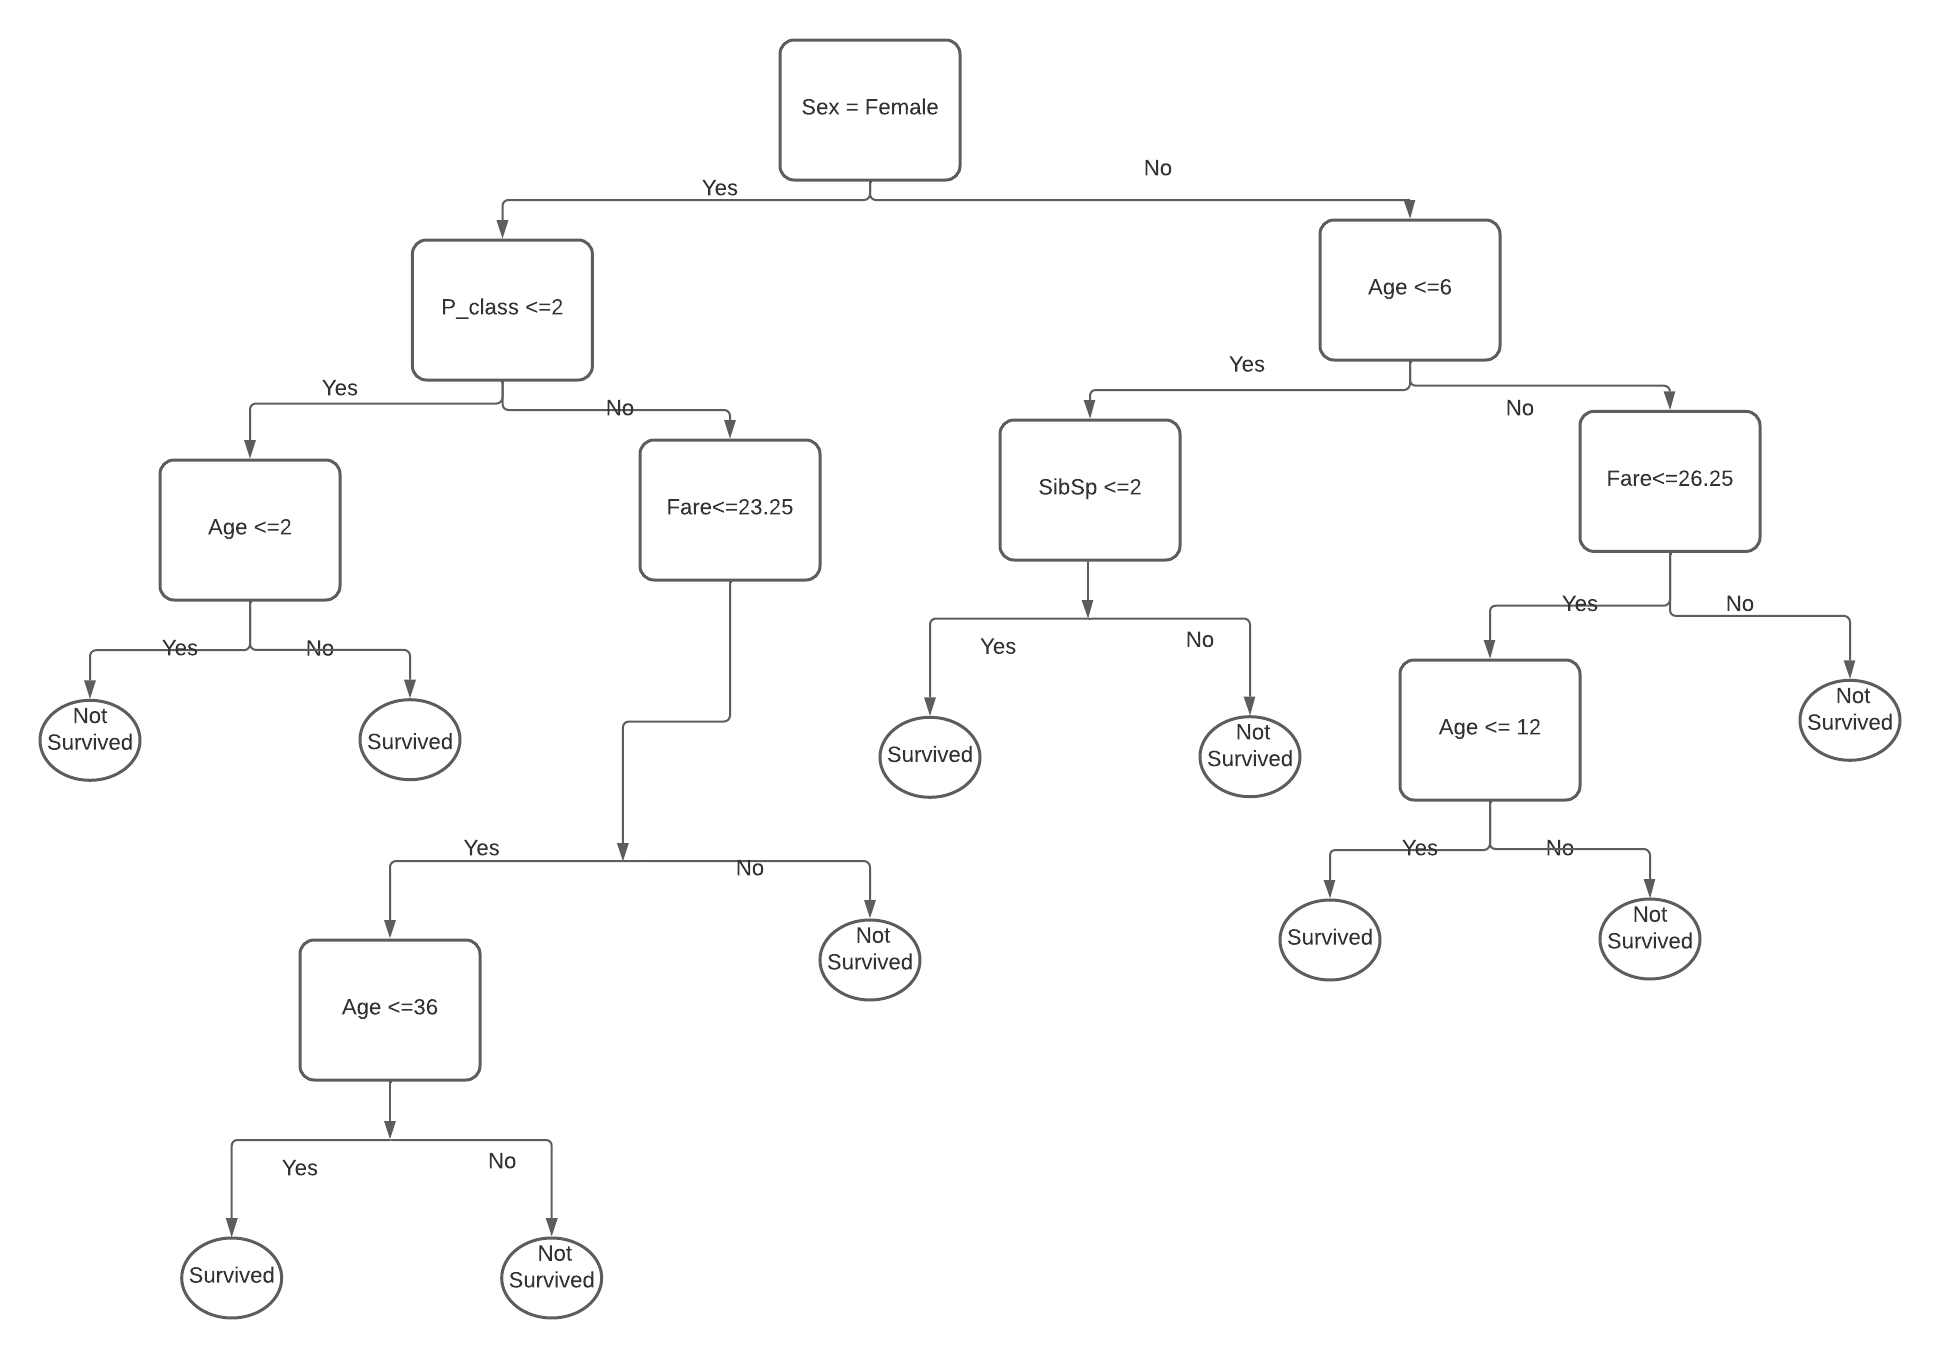

### get predictions

In [23]:
def traverse_tree(x, tree,feature_names=None):
    if not isinstance(tree,dict): # returns the answer when we reach the leaf node 
        # (leaf node is not a dictionary but a label)
        return tree
    else: 
        # traverse the tree by letting the values of test data be tested agianst the feature and value at each node
        question = list(tree.keys())[0]
        name,sign,value = question.split() # get feature name (idx), sign (== or <=), and feature value
        name = list(feature_names).index(name) if feature_names is not None else name # convert idx into real name
        if sign == '==': # for categorical variable
            if x[int(name)]==value:
                tree = list(tree[question])[0] # if condition holds, go to left child 
            else:
                tree = list(tree[question])[1] # if not, go to right child 
        else: # for numerical variable
            if x[int(name)]<= float(value):
                tree = list(tree[question])[0]
            else:
                tree = list(tree[question])[1]
        return traverse_tree(x,tree,feature_names) # recursively traverse the tree
    
def predict(X,tree,feature_names=None): # gathering all x's in X 
    if isinstance(X,pd.DataFrame):
        X = np.array(X)
    return [traverse_tree(x,tree,feature_names) for x in X]

In [24]:
X_test[['Age']] =imp.transform(X_test[['Age']])
X_test[['Embarked']] =imp2.transform(X_test[['Embarked']])
y_test_named = pd.cut(y_test,2,labels=['Not_Survived','Survived']).to_numpy()

In [28]:
y_pred = predict(X_test,tree,feature_names=df.columns[1:])

In [29]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test_named,y_pred))

0.8246268656716418


In [30]:
print(confusion_matrix(y_test_named,y_pred))

[[143  14]
 [ 33  78]]
